In [1]:
import numpy as np
import os
from netCDF4 import Dataset
from argo_nn.Grabber import *
from argo_nn.TS_Parser import *
from GeneralUtilities.Data.Filepath.instance import get_data_folder as get_base_folder

In [2]:
argo_folder = os.path.join(get_base_folder(), 'Raw/Argo')
radius = 3

for filename in os.listdir(argo_folder)[:1]:
        subfolder = os.path.join(argo_folder, filename)
        print('Currently traversing', filename)

        # for the sake of testing, only go through 1 file in each subfolder
        for f in os.listdir(subfolder)[:1]:
            print('Looking at float', f)

            prof_file = os.path.join(subfolder, f, f'{f}_prof.nc')
            ds = Dataset(prof_file)

Currently traversing bodc
Looking at float 1901932


In [3]:
ds2 = Dataset('/data/SO2/fkalkin/DataDir/Raw/Argo/temp-sal/RG_ArgoClim_Salinity_2019.nc')
desired_pres = ds2['PRESSURE'][25:56]

In [4]:
import matplotlib.pyplot as plt

In [5]:
# plot a bunch of profiles

count = 0
for var in ['TEMP', 'PSAL']:
  for i in range(len(ds['PRES'])):
     
    ip = interpolate(ds['PRES'][i], ds2['PRESSURE'][25:56], ds[var][i], ds['PRES_QC'][i], ds[f'{var}_QC'][i])
    if ip is None:
      count += 1
      continue
    # plt.scatter(ip, ds2['PRESSURE'][25:56], marker='o')
    # plt.scatter(ds[var][i], ds['PRES'][i], marker='x')
    # plt.legend(['Interpolated', 'Real'])
    # plt.title(f'interpolated {var} values')
    # plt.gca().invert_yaxis()
    # plt.show()

count, len(ds['PRES'])

(27, 73)

In [6]:
from argo_nn.TS_Parser import *
with open('../eofs/u.pkl', 'rb') as f:
    ut = pickle.load(f).T

with open('../eofs/means.pkl', 'rb') as f:
    means = pickle.load(f)
ut.shape, means.shape

((62, 62), (62,))

In [15]:
xplot = np.array([])
yplots = np.array([])

t_approx = np.array([])
s_approx = np.array([])
t_interp = np.array([])
s_interp = np.array([])
# gather data for accuracy plots

for num in range(4, 17, 2):

    for filename in os.listdir(argo_folder)[:1]:
        subfolder = os.path.join(argo_folder, filename)
        print('Currently traversing', filename)

        for f in os.listdir(subfolder)[:10]:
            # print('Looking at float', f)

            prof_file = os.path.join(subfolder, f, f'{f}_prof.nc')
            ds = Dataset(prof_file)

            for i in range(len(ds['PRES'])):

                # process profile
                approx, t, s = process_profile(ds['PRES'][i], desired_pres, ds['TEMP'][i], ds['PSAL'][i], 
                                               ds['PRES_QC'][i], ds['TEMP_QC'][i], ds['PSAL_QC'][i], num, means, ut)
                
                if approx is None:
                    continue
                
                if num == 8:
                #     xplot = np.append(xplot, np.append(t, s))
                    t_interp = np.append(t_interp, t)
                    s_interp = np.append(s_interp, s)
                # yplots = np.append(yplots, approx)
                t_approx = np.append(t_approx, approx[:31])
                s_approx = np.append(s_approx, approx[31:])

# yplots = np.reshape(yplots, (7, -1))
t_approx = np.reshape(t_approx, (7, -1))
s_approx = np.reshape(s_approx, (7, -1))

Currently traversing bodc
Currently traversing bodc
Currently traversing bodc
Currently traversing bodc
Currently traversing bodc
Currently traversing bodc
Currently traversing bodc


In [16]:
np.shape(t_interp), np.shape(t_approx)

((21204,), (7, 21204))

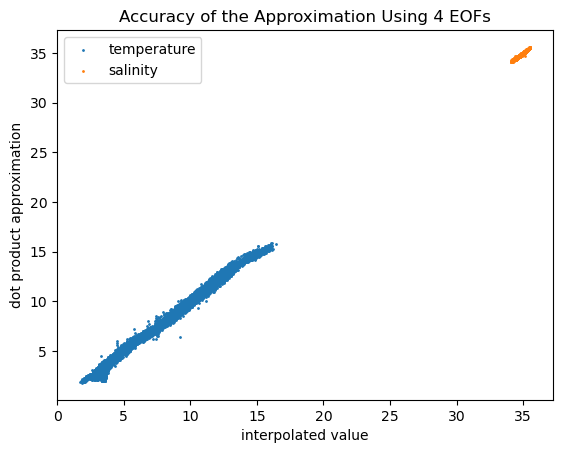

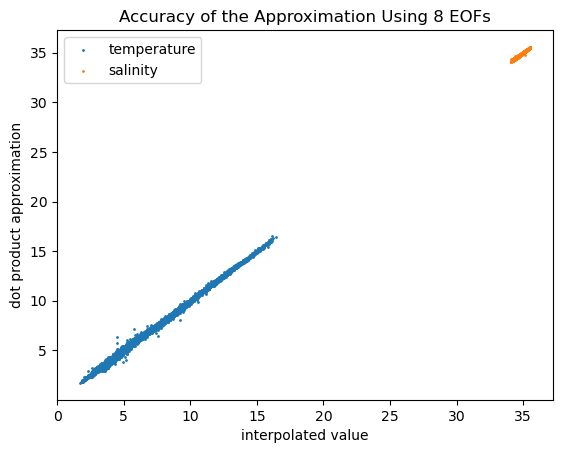

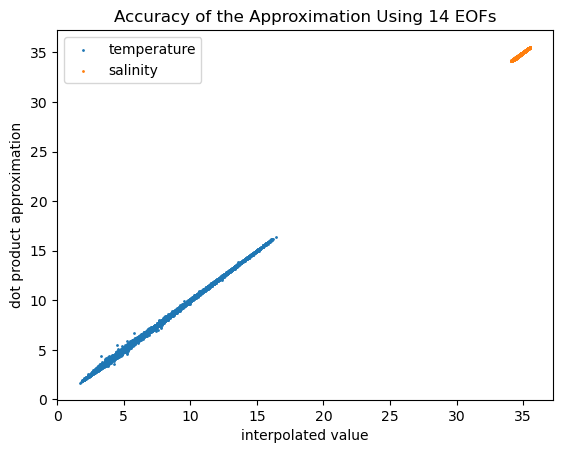

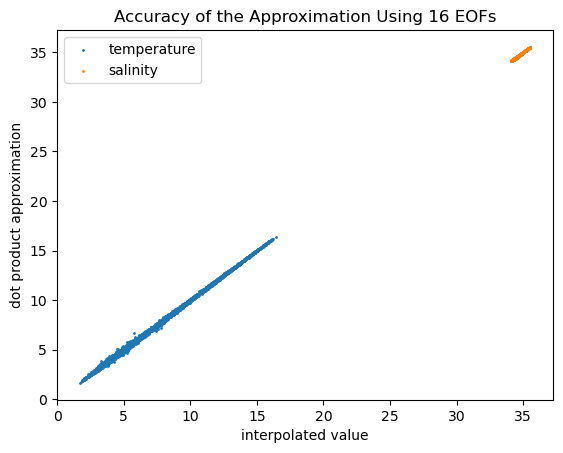

In [17]:
for num in [0, 2, 5, 6]:
    # plt.scatter(xplot, yplots[num], s=1, alpha=1)
    plt.scatter(t_interp, t_approx[num], s=1, alpha=1)
    plt.scatter(s_interp, s_approx[num], s=1, alpha=1)
    plt.legend(['temperature', 'salinity'])
    plt.xlabel('interpolated value')
    plt.ylabel('dot product approximation')
    plt.title(f'Accuracy of the Approximation Using {num*2 + 4} EOFs')
    plt.show()

[0.1178104821639653, 0.03507368014799039, 0.01643789017200758, 0.008337340952017786, 0.005382235910119466, 0.0040525417389384215, 0.0031281996104088224] [0.0018092909866278956, 0.0005796630444539974, 0.000334647890074711, 0.00019662663773113237, 0.00013284599750624693, 0.00010031674681260979, 7.712934159071756e-05]


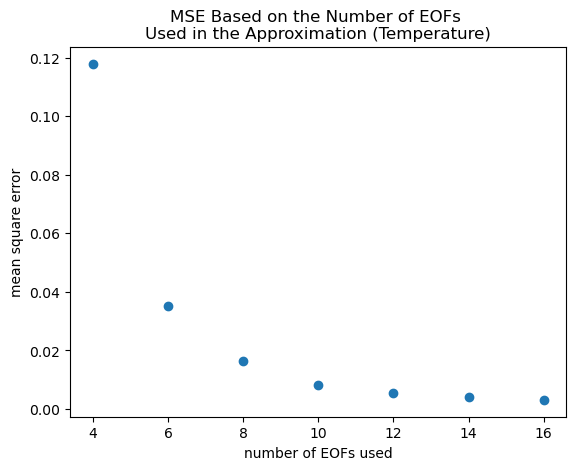

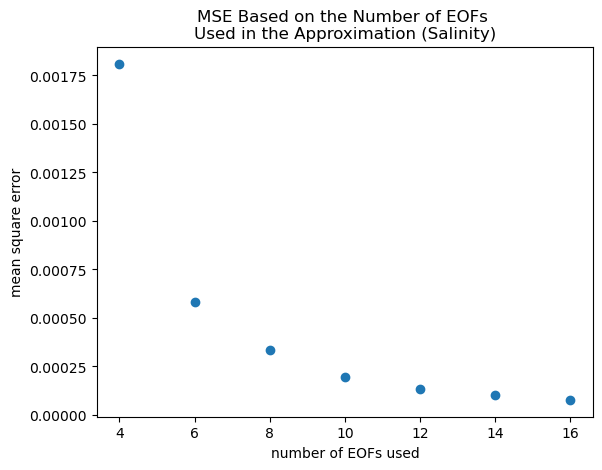

In [19]:
t_MSEs = [np.mean((y-t_interp)**2) for y in t_approx]
s_MSEs = [np.mean((y-s_interp)**2) for y in s_approx]
print(t_MSEs, s_MSEs)

plt.scatter(np.arange(4, 17, 2), t_MSEs)
plt.xlabel('number of EOFs used')
plt.ylabel('mean square error')
plt.title('MSE Based on the Number of EOFs \nUsed in the Approximation (Temperature)')
plt.show()

plt.scatter(np.arange(4, 17, 2), s_MSEs)
plt.xlabel('number of EOFs used')
plt.ylabel('mean square error')
plt.title('MSE Based on the Number of EOFs \nUsed in the Approximation (Salinity)')
plt.show()

# MAEs = [np.mean(np.abs(y-xplot)) for y in yplots]
# print(MAEs)

# plt.scatter(np.arange(4, 17, 2), MAEs)
# plt.xlabel('number of EOFs used')
# plt.ylabel('mean absolute deviation')
# plt.title('MAD Based on the Number of EOFs Used in the Approximation')
# plt.show()

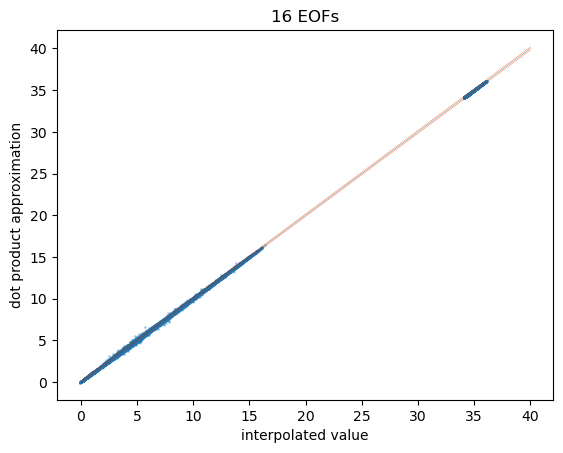

In [10]:
def catch_outlier(x, y, std):
    return y > x + 5*std or y < x - 5*std

std = np.std(yplots[-1]-xplot)
plt.plot([0, 40], [0, 40], color='green', linewidth=0.2)
plt.plot([0, 40], [0+3*std, 40+5*std], color='red', linewidth=0.2)
plt.plot([0, 40], [0-3*std, 40-5*std], color='red', linewidth=0.2)
plt.scatter(xplot, yplots[-1], s=1, alpha=0.3)
plt.xlabel('interpolated value')
plt.ylabel('dot product approximation')
plt.title(f'16 EOFs')
plt.show()

In [12]:
for i in range(4):
    print(np.std(yplots[i]-xplot))

0.25285933163133667
0.12442179399167366
0.08004059085306653
0.05979361393207465


Currently traversing bodc
Looking at float 1901932
ERROR IN FLOAT 1901932 of bodc at trajectory #0


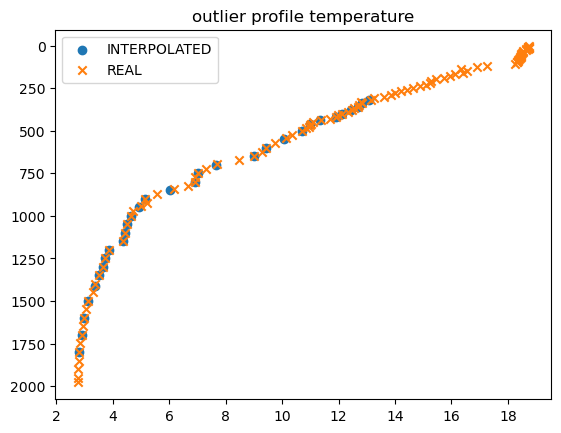

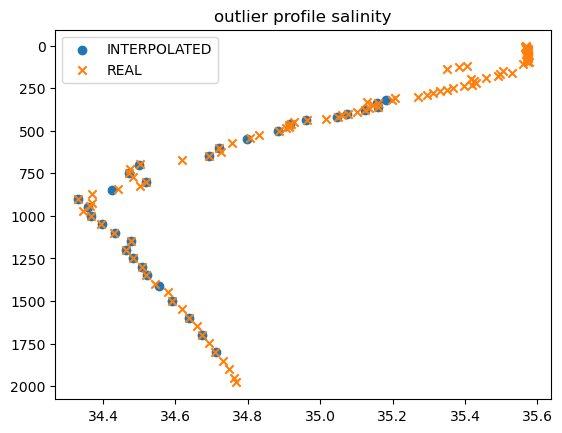

Looking at float 1901848
ERROR IN FLOAT 1901848 of bodc at trajectory #61


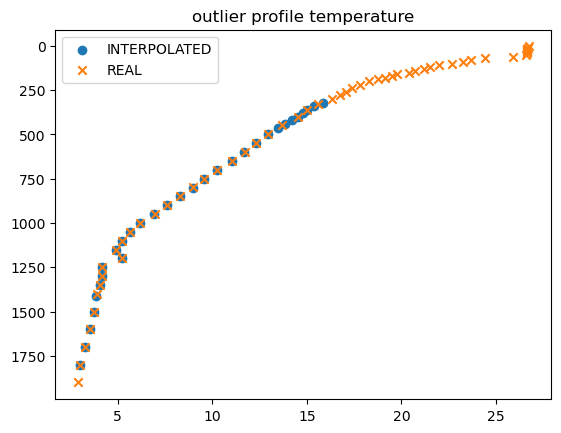

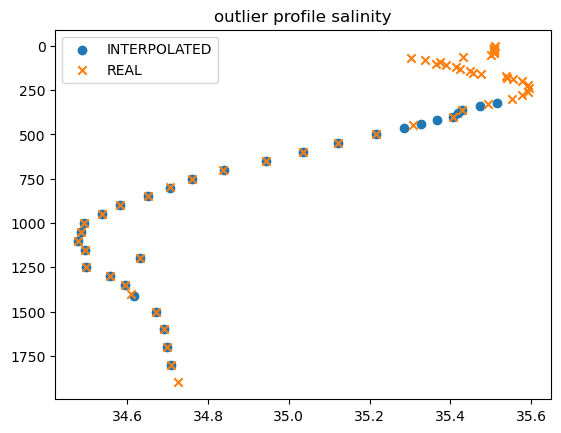

Looking at float 6900614
Looking at float 6901171
ERROR IN FLOAT 6901171 of bodc at trajectory #137


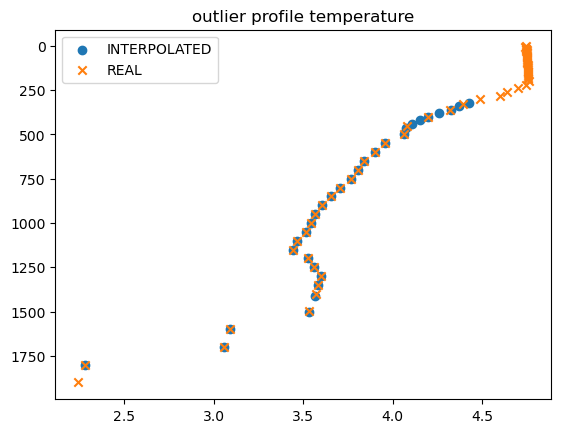

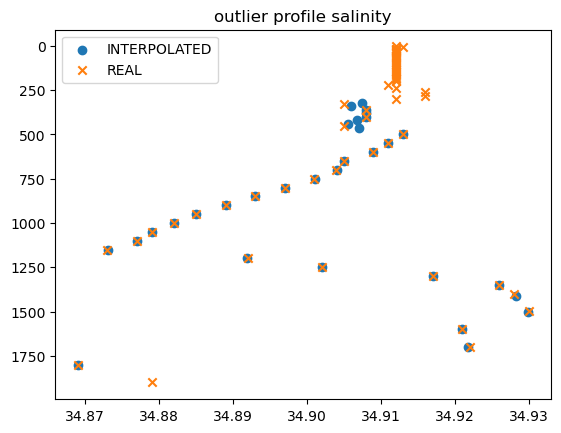

Looking at float 1900294
ERROR IN FLOAT 1900294 of bodc at trajectory #41


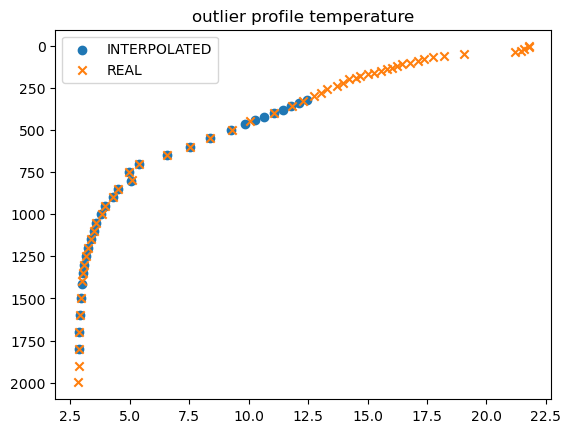

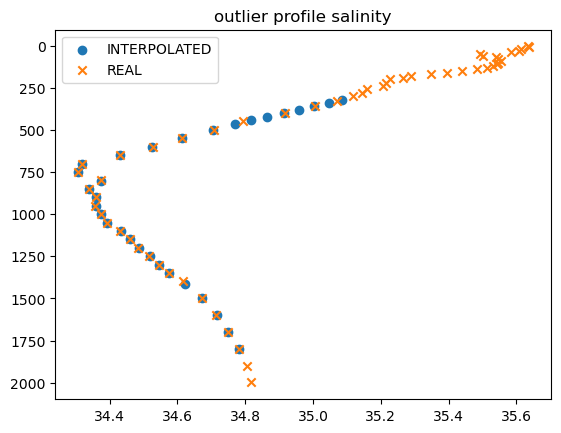

Looking at float 3901516
ERROR IN FLOAT 3901516 of bodc at trajectory #24


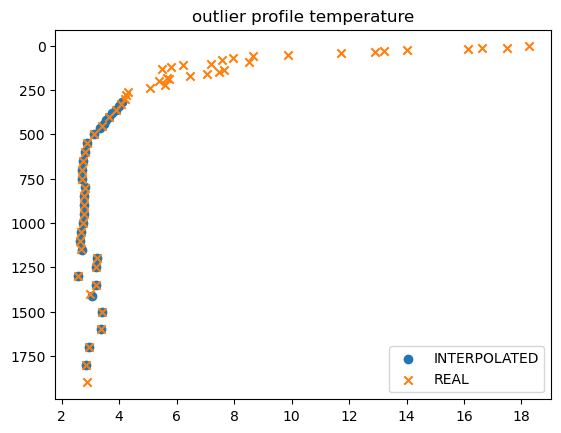

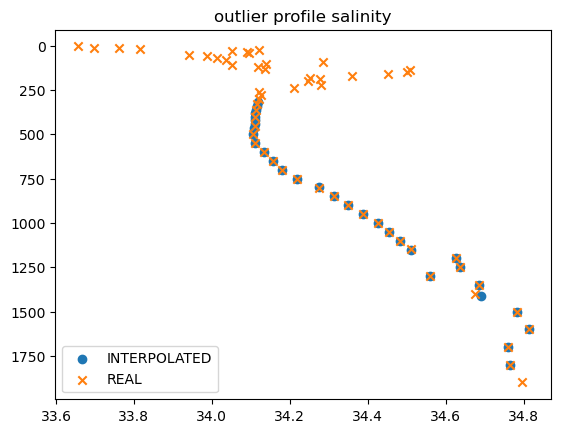

Looking at float 3901561
ERROR IN FLOAT 3901561 of bodc at trajectory #5


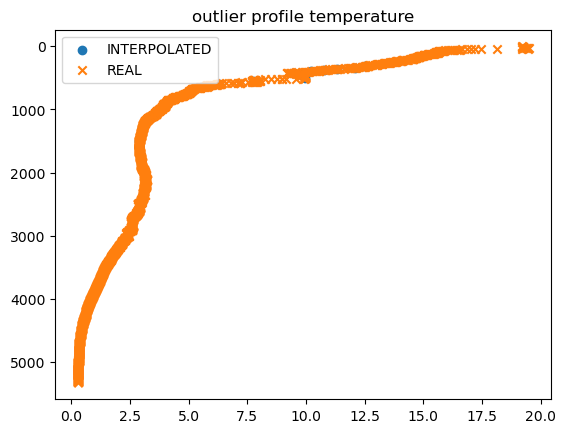

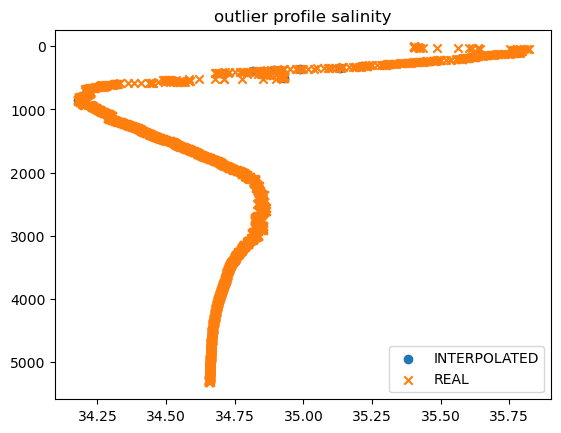

Looking at float 6904182
Looking at float 1901055
ERROR IN FLOAT 1901055 of bodc at trajectory #23


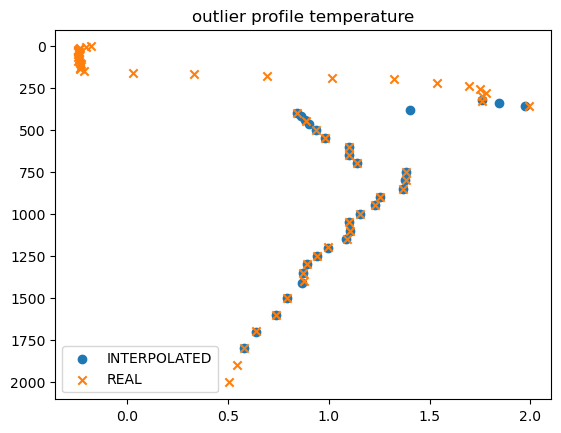

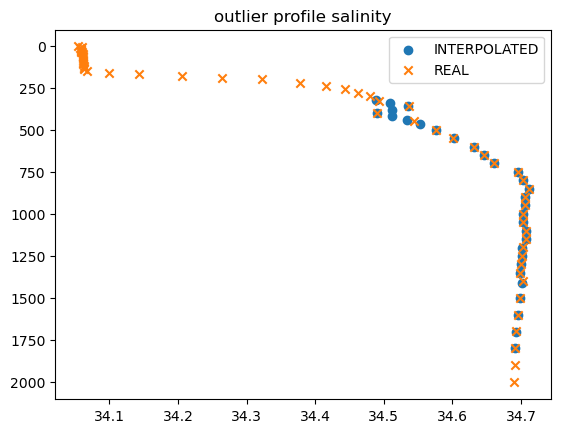

Looking at float 3900309
ERROR IN FLOAT 3900309 of bodc at trajectory #109


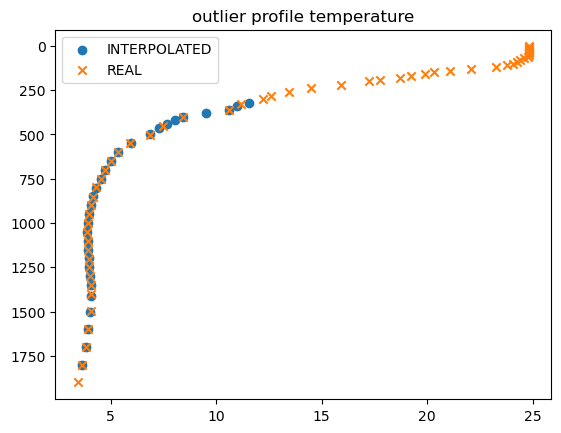

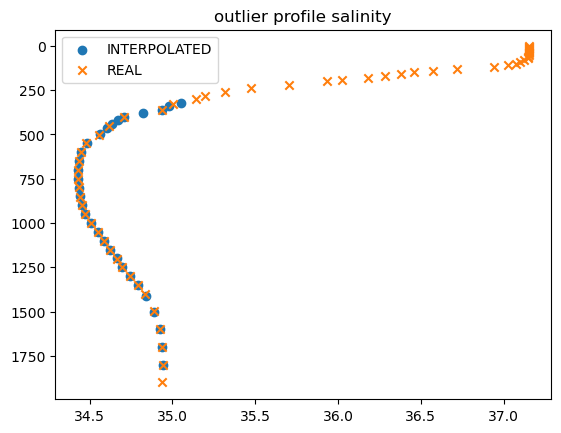

In [11]:
for filename in os.listdir(argo_folder)[:1]:
    subfolder = os.path.join(argo_folder, filename)
    print('Currently traversing', filename)

    for f in os.listdir(subfolder)[:10]:
        print('Looking at float', f)

        prof_file = os.path.join(subfolder, f, f'{f}_prof.nc')
        ds = Dataset(prof_file)

        if ds['DATA_MODE'] == b'R':
                continue

        for i in range(len(ds['PRES'])):

            approx, t, s = process_profile(ds['PRES'][i], desired_pres, ds['TEMP'][i], ds['PSAL'][i], ds['PRES_QC'][i], 
                            ds['TEMP_QC'][i], ds['PSAL_QC'][i], 16, means, ut)

            if approx is None:
                 continue
            
            flag = False
            for diff in np.abs(approx - np.append(t, s)):
                if diff > 0.3:
                    flag = True
            if flag:
                print(f'ERROR IN FLOAT {f} of {filename} at trajectory #{i}')
                plt.scatter(t, desired_pres, marker='o')
                plt.scatter(ds['TEMP'][i], ds['PRES'][i], marker='x')
                plt.title(f'outlier profile temperature')
                plt.legend(['INTERPOLATED', 'REAL'])
                plt.gca().invert_yaxis()
                plt.show()

                plt.scatter(s, desired_pres, marker='o')
                plt.scatter(ds['PSAL'][i], ds['PRES'][i], marker='x')
                plt.legend(['INTERPOLATED', 'REAL'])
                plt.title(f'outlier profile salinity')
                plt.gca().invert_yaxis()
                plt.show()
                break